 # Proyecto 3: Clustering
 ----
  
  University : UTEC \
  Course       : Machine Learning \
  Professor    : Cristian López Del Alamo 
  
 ----

Write the names and surnames of the members and the percentage of participation of each one in the development of the practice:
 - Integrante 1: Miguel Lama Carrasco(100%)
 - Integrante 2: Josue Arbulú Pastor(100%)
 - Integrante 3: Aaron SataMaria Gutierrez(100%)
 - Integrante 4: Lenin Chavez Zapata(100%)


 ----

## Importación de librerías

In [1319]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_blobs
from sklearn.neighbors import KDTree
from sklearn.model_selection import train_test_split
from matplotlib.patches import Ellipse
from sklearn import random_projection
import umap
import matplotlib.pyplot as plt
from scipy.stats import mode

# Dataset r2plus1d_34_8_ig65m_ft_kinetics

## Procesar los features extraídos

### Obtener un feature vector por cada video

In [1323]:
def process_video_data(features_path, labels_data):
    features_list = []
    labels_list = []
    urls_list = []
    empty_frame_count = 0
    empty_frame_ids = []

    for video_file in glob.glob(os.path.join(features_path, "*.npy")):
        video_id = os.path.basename(video_file).split("_")[0]
        feature_array = np.load(video_file)

        if feature_array.size == 0:
            empty_frame_count += 1
            empty_frame_ids.append(video_id)
            continue

        avg_feature = np.mean(feature_array, axis=0)
        features_list.append(avg_feature)

        label = labels_data[labels_data["youtube_id"] == video_id]["label"].values[0]
        labels_list.append(label)

        url = labels_data[labels_data["youtube_id"] == video_id]["youtube_id"].values[0]
        urls_list.append(url)

    print(f"Number of empty videos not included ({features_path}): {empty_frame_count}")
    print(f"Labels of empty videos not included: {empty_frame_ids}")

    stacked_features = np.vstack(features_list)
    stacked_labels = np.vstack(labels_list)
    stacked_urls = np.vstack(urls_list)

    features_df = pd.DataFrame(stacked_features)
    labels_df = pd.DataFrame(stacked_labels)
    urls_df = pd.DataFrame(stacked_urls, columns=["youtube_id"])

    return urls_df, features_df, labels_df

In [1324]:

df_train_labels = pd.read_csv(
    "./url_data/train_subset_10.csv", header=None, names=["youtube_id", "label"]
)
df_val_labels = pd.read_csv(
    "./url_data/val_subset_10.csv", header=None, names=["youtube_id", "label"]
)
df_test_labels = pd.read_csv(
    "./url_data/test_subset_10.csv", header=None, names=["youtube_id", "label"]
)
df_train_labels.drop(index=df_train_labels.index[0], axis=0, inplace=True)
df_val_labels.drop(index=df_val_labels.index[0], axis=0, inplace=True)
df_test_labels.drop(index=df_test_labels.index[0], axis=0, inplace=True)

df_test_labels.head()

,youtube_id,label
1,oaVWnxlQOeo,NaN
2,7zMBk9Zu9fY,NaN
3,DwPEZeX5WkA,NaN
4,bO1MW9Lq9Sg,NaN
5,TdBpD9Ccg9w,NaN


In [1325]:
models_r21d = ["r2plus1d_18_16_kinetics","r2plus1d_34_32_ig65m_ft_kinetics","r2plus1d_34_8_ig65m_ft_kinetics"]
for path in models_r21d:
    
    # train
    print("train")
    urls_train, X_train, Y_train = process_video_data(
    f"./numpy_data/train/r21d/{path}/", df_train_labels)
    urls_train.dropna(inplace=True)
    X_train.dropna(inplace=True)
    Y_train.dropna(inplace=True)
    train_data_extracted_df = pd.concat([urls_train, X_train, Y_train], axis=1)
    # Exportar a un archivo CSV
    train_data_extracted_df.to_csv(f'./csv_data/train_data_{path}.csv', index=False)
    print("")
    # val
    print("val")
    urls_val, X_val, Y_val = process_video_data(
    f"./numpy_data/val/r21d/{path}/", df_val_labels)
    urls_val.dropna(inplace=True)
    X_val.dropna(inplace=True)
    Y_val.dropna(inplace=True)
    val_data_extracted_df = pd.concat([urls_val, X_val, Y_val], axis=1)
    # Exportar a un archivo CSV
    val_data_extracted_df.to_csv(f'./csv_data/val_data_{path}.csv', index=False)
    print("")
    # test
    print("test")
    urls_test, X_test, Y_test = process_video_data(
    f"./numpy_data/test/r21d/{path}/", df_test_labels)
    urls_test.dropna(inplace=True)
    X_test.dropna(inplace=True)
    Y_test.dropna(inplace=True)
    test_data_extracted_df = pd.concat([urls_test, X_test], axis=1)
    # Exportar a un archivo CSV
    test_data_extracted_df.to_csv(f'./csv_data/test_data_{path}.csv', index=False)
    print("")

train
Number of empty videos not included (./numpy_data/train/r21d/r2plus1d_18_16_kinetics/): 1
Labels of empty videos not included: ['W6TspTTHpzA']

val
Number of empty videos not included (./numpy_data/val/r21d/r2plus1d_18_16_kinetics/): 0
Labels of empty videos not included: []

test
Number of empty videos not included (./numpy_data/test/r21d/r2plus1d_18_16_kinetics/): 0
Labels of empty videos not included: []

train
Number of empty videos not included (./numpy_data/train/r21d/r2plus1d_34_32_ig65m_ft_kinetics/): 6
Labels of empty videos not included: ['EQULJzMzmeM', 'W6TspTTHpzA', '-reNwipPPdQ', 'oRwkPwoFIL8', 'yqJXWU8BXEQ', 'B3L0x-AsCZ4']

val
Number of empty videos not included (./numpy_data/val/r21d/r2plus1d_34_32_ig65m_ft_kinetics/): 0
Labels of empty videos not included: []

test
Number of empty videos not included (./numpy_data/test/r21d/r2plus1d_34_32_ig65m_ft_kinetics/): 1
Labels of empty videos not included: ['se3ihwZ56Uw']

train
Number of empty videos not included (./nump

### Obtener la data de entrenamiento, validación y de testeo

In [1327]:
urls_train, X_train, Y_train = process_video_data(
    f"./numpy_data/train/r21d/{models_r21d[2]}/", df_train_labels
)

urls_train.dropna(inplace=True)
X_train.dropna(inplace=True)
Y_train.dropna(inplace=True)

print(f"\nNúmero de videos cargados para entrenamiento: {len(X_train)}")
print(f"Shape de nuestra matriz de videos para entrenamiento: {X_train.shape}")


Number of empty videos not included (./numpy_data/train/r21d/r2plus1d_34_8_ig65m_ft_kinetics/): 0
Labels of empty videos not included: []

Número de videos cargados para entrenamiento: 5415
Shape de nuestra matriz de videos para entrenamiento: (5415, 512)


In [1328]:
urls_val, X_val, Y_val = process_video_data(
    f"./numpy_data/val/r21d/{models_r21d[2]}/", df_val_labels
)

urls_val.dropna(inplace=True)
X_val.dropna(inplace=True)
Y_val.dropna(inplace=True)

print(f"\nNúmero de videos cargados para validación: {len(X_val)}")
print(f"Shape de nuestra matriz de videos para validación: {X_val.shape}")


Number of empty videos not included (./numpy_data/val/r21d/r2plus1d_34_8_ig65m_ft_kinetics/): 0
Labels of empty videos not included: []

Número de videos cargados para validación: 426
Shape de nuestra matriz de videos para validación: (426, 512)


In [1329]:
urls_test, X_test, Y_test = process_video_data(
    f"./numpy_data/test/r21d/{models_r21d[2]}/", df_test_labels
)
urls_test.dropna(inplace=True)
X_test.dropna(inplace=True)
Y_test.dropna(inplace=True)

print(f"\nNúmero de videos cargados para testeo: {len(X_test)}")
print(f"Shape de nuestra matriz de videos para testeo: {X_test.shape}")

Number of empty videos not included (./numpy_data/test/r21d/r2plus1d_34_8_ig65m_ft_kinetics/): 0
Labels of empty videos not included: []

Número de videos cargados para testeo: 805
Shape de nuestra matriz de videos para testeo: (805, 512)


## Preprocesamiento de la data

### Escalar los datos

In [1332]:
Scaler = PowerTransformer(method="yeo-johnson") # Utilizaremos el PowerTransformer para asemejar la data a una forma gaussiana
X_train_s = Scaler.fit_transform(X_train)
X_val_s = Scaler.transform(X_val)
X_test_s = Scaler.transform(X_test)


### Reduce dimensionality

#### Random Projection

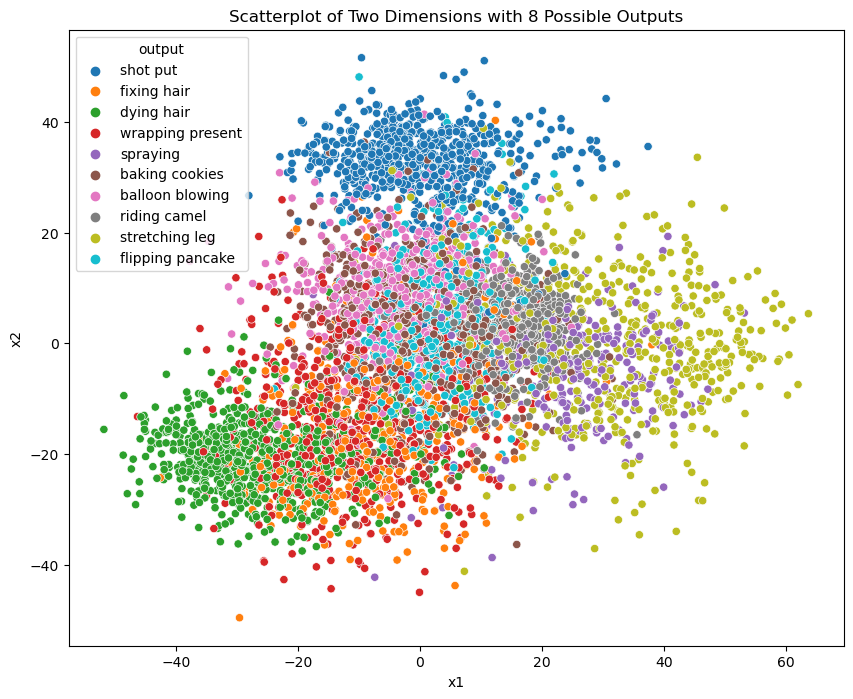

In [1335]:
RP = random_projection.GaussianRandomProjection(n_components=2,random_state=12)
X_train_rp = RP.fit_transform(X_train_s)
X_val_rp = RP.transform(X_val_s)
X_test_rp = RP.transform(X_test_s)
X_train_rp.shape
df_ = pd.concat([pd.DataFrame(X_train_rp), Y_train], axis = 1)
df_.columns = ["x1","x2","output"]
# Crear el scatterplot con Seaborn
plt.figure(figsize=(10, 8))
scatter_plot = sns.scatterplot(data=df_, x='x1', y='x2', hue='output')
plt.title('Scatterplot of Two Dimensions with 8 Possible Outputs')
plt.show()

#### UMAP

/opt/anaconda3/envs/MachineL/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


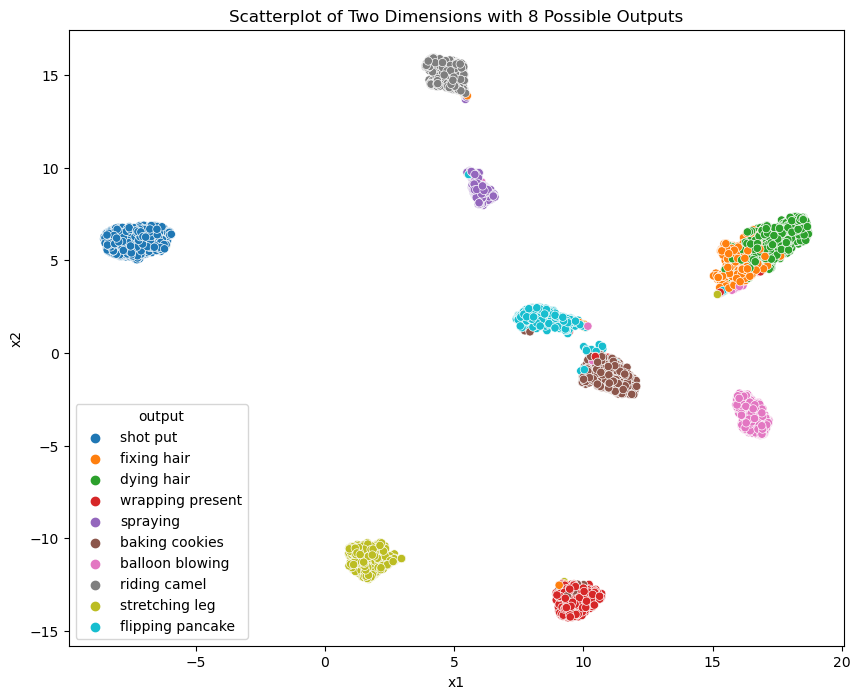

In [1337]:
UMAP = umap.UMAP(random_state=12, n_jobs=-1)
X_train_umap = UMAP.fit_transform(X_train_s)
X_val_umap = UMAP.transform(X_val_s)
X_test_umap = UMAP.transform(X_test_s)
X_train_umap.shape
df_ = pd.concat([pd.DataFrame(X_train_umap), Y_train], axis = 1)
df_.columns = ["x1","x2","output"]
# Crear el scatterplot con Seaborn
plt.figure(figsize=(10, 8))
scatter_plot = sns.scatterplot(data=df_, x='x1', y='x2', hue='output')
plt.title('Scatterplot of Two Dimensions with 8 Possible Outputs')
plt.show()

#### PCA

(5415, 100)


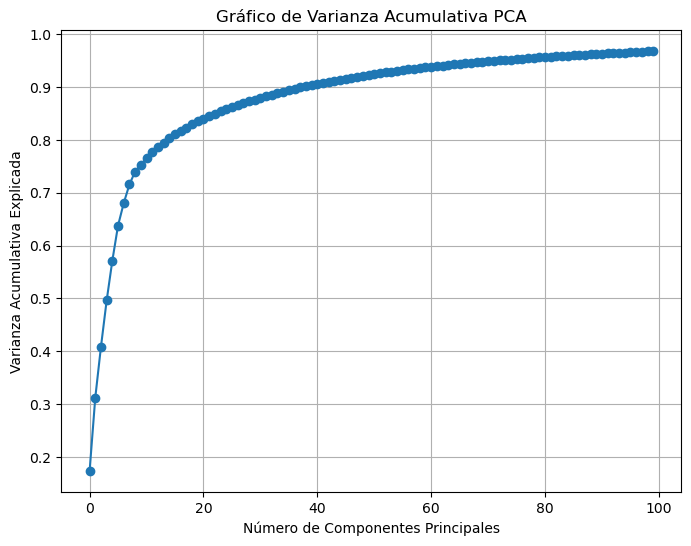

In [1339]:
pca = PCA(n_components=100,random_state=12)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape)

explained_variance = pca.explained_variance_ratio_
# Assuming 'explained_variance' is already defined
cumulative_variance = np.cumsum(explained_variance)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(np.arange(0, 100), cumulative_variance[:100], marker='o', linestyle='-')
plt.title('Gráfico de Varianza Acumulativa PCA')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Acumulativa Explicada')
plt.grid(True)
plt.show()

## Función para exportar test

In [1341]:
def create_clustered_dataframe(pred, output_csv_path):
    test_export = pd.concat([urls_test,pd.DataFrame(pred)], axis=1)
    test_export.columns = ["youtube_id", "labels"]
    test_url_sort = pd.read_csv(
    "./url_data/test_subset_10.csv", header=None, names=["youtube_id"]
    )
    test_url_sort.drop(index=test_url_sort.index[0], axis=0, inplace=True)
    
    # Merge de los dos DataFrames basado en youtube_id
    merged_df = pd.merge(test_url_sort, test_export, on='youtube_id', how='left')

    # Guardar el DataFrame resultante en un nuevo CSV
    merged_df.to_csv(output_csv_path, index=False)
    
def create_clustered_missing_dataframe(pred, output_csv_path):
    test_export = pd.concat([urls_test, pd.DataFrame(pred)], axis=1)
    test_export.columns = ["youtube_id", "labels"]
    
    test_url_sort = pd.read_csv(
        "./url_data/test_subset_10.csv", header=None, names=["youtube_id"]
    )
    test_url_sort.drop(index=test_url_sort.index[0], axis=0, inplace=True)
    
    # Añadir las filas faltantes con label 0
    missing_ids = test_url_sort[~test_url_sort['youtube_id'].isin(test_export['youtube_id'])]
    missing_ids['labels'] = 0
    
    # Concatenar las filas faltantes al test_export
    test_export = pd.concat([test_export, missing_ids], axis=0)
    
    # Merge de los dos DataFrames basado en youtube_id
    merged_df = pd.merge(test_url_sort, test_export, on='youtube_id', how='left')

    # Guardar el DataFrame resultante en un nuevo CSV
    merged_df.to_csv(output_csv_path, index=False)

## Clustering in 2d

### Kmeans

In [1344]:
def distance(x1, x2):
    return np.linalg.norm(x1 - x2, axis=0)
    
class KMeans_:
    def __init__(self, K=5, max_iters=1000, tol=1e-4, random_state=None, init='kmeans++'):
        self.K = K
        self.max_iters = max_iters
        self.tol = tol  # Tolerancia para la convergencia
        self.random_state = random_state  # Semilla para la reproducibilidad
        self.init = init  # Método de inicialización ('random' o 'kmeans++')

    def fit(self, X):
        if self.random_state is not None:
            np.random.seed(self.random_state)
        
        self.X = X
        self.n_samples, self.n_features = X.shape

        # Initialize centroids
        if self.init == 'random':
            random_sample_idxs = np.random.choice(self.n_samples, self.K, replace=False)
            self.centroids = self.X[random_sample_idxs]
        elif self.init == 'kmeans++':
            self.centroids = self._initialize_centroids_kmeanspp()

        for _ in range(self.max_iters):
            # Assign samples to closest centroids (create clusters)
            labels = self._assign_clusters(self.centroids)

            # Calculate new centroids from the clusters
            centroids_old = self.centroids
            self.centroids = self._calculate_centroids(labels)

            # Check for convergence
            if self._is_converged(centroids_old, self.centroids):
                break

    def predict(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

    def _assign_clusters(self, centroids):
        distances = np.linalg.norm(self.X[:, np.newaxis] - centroids, axis=2)
        return np.argmin(distances, axis=1)

    def _calculate_centroids(self, labels):
        centroids = np.zeros((self.K, self.n_features))
        for k in range(self.K):
            cluster_points = self.X[labels == k]
            if len(cluster_points) > 0:
                centroids[k] = cluster_points.mean(axis=0)
        return centroids

    def _is_converged(self, centroids_old, centroids):
        # Check if the sum of the distances between old and new centroids is less than the tolerance
        distances = np.linalg.norm(centroids_old - centroids, axis=1)
        return np.all(distances < self.tol)
    
    def _initialize_centroids_kmeanspp(self):
        centroids = []
        # Step 1: Randomly select the first centroid from the data points
        first_centroid_idx = np.random.choice(self.n_samples)
        centroids.append(self.X[first_centroid_idx])
        
        for _ in range(1, self.K):
            # Step 2: Compute the distance between each point and the nearest centroid
            distances = np.min([np.linalg.norm(self.X - c, axis=1) for c in centroids], axis=0)
            # Step 3: Select the next centroid with a probability proportional to the square of the distance
            probabilities = distances ** 2 / np.sum(distances ** 2)
            next_centroid_idx = np.random.choice(self.n_samples, p=probabilities)
            centroids.append(self.X[next_centroid_idx])
        
        return np.array(centroids)

In [1345]:
def plot_scatter_kmeans(X, model, labels):
    # Plot the data points and their cluster assignments
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
    ax.scatter(model.centroids[:, 0], model.centroids[:, 1],
           marker='.', color='black', s=100 , linewidths=3)
    # Set light blue background 

    ax.set_title("K-means Clustering")
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")

    plt.show()



#### Train

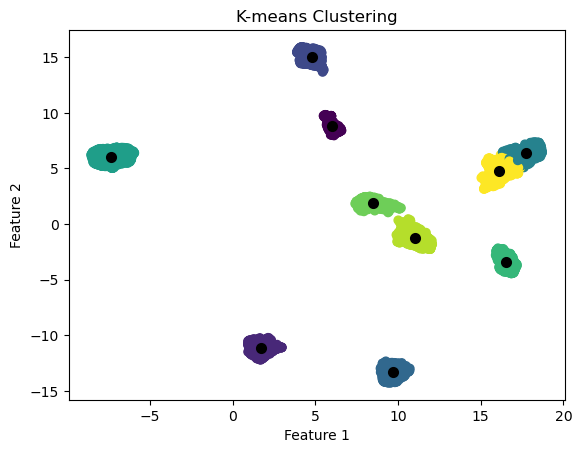

In [1347]:
kmeans = KMeans_(K=10, random_state=12)
kmeans.fit(X_train_umap)
# Instanciar LabelEncoder
le = LabelEncoder()
train_pred = kmeans.predict(X_train_umap)
train_labels = le.fit_transform(np.array(Y_train).reshape(Y_train.shape[0]))

plot_scatter_kmeans(X_train_umap, kmeans, train_pred)

#### Val

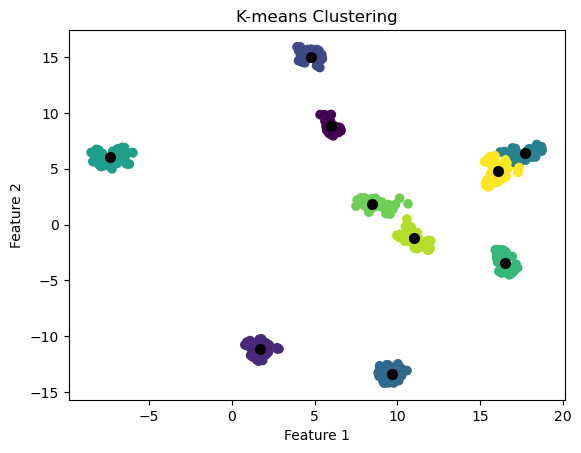

In [1349]:
val_pred = kmeans.predict(X_val_umap)
val_labels = le.fit_transform(np.array(Y_val).reshape(Y_val.shape[0]))

plot_scatter_kmeans(X_val_umap, kmeans, val_pred)

#### Results

In [1351]:
print(adjusted_rand_score(val_labels, val_pred))
print(silhouette_score(X_val_umap, val_pred))

0.8602169882076558
0.7711579


#### Test classification

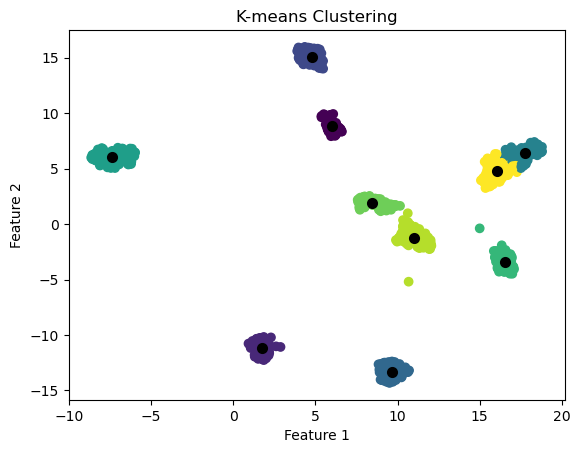

In [1353]:
test_pred = kmeans.predict(X_test_umap)
plot_scatter_kmeans(X_test_umap, kmeans, test_pred)
create_clustered_dataframe(test_pred,'./output/r2plus1d_34_8_ig65m_ft_kinetics/test_output_2d_kmeanspp.csv')


### Dbscan

In [1355]:
class DBSCAN_:
    def __init__(self, radius=1, min_neighbors=5,random_state=None):
        self.radius = radius
        self.min_neighbors = min_neighbors
        self.labels_ = None
        self.tree_ = None
        self.data_ = None
        self.random_state = random_state  # Semilla para la reproducibilidad

    def fit(self, data):
        if self.random_state is not None:
            np.random.seed(self.random_state)
        self.data_ = data
        self.tree_ = KDTree(data)
        n, _ = data.shape
        counter = 0
        labels = [-1 for _ in range(n)]
        label_count = -1
        stack = [0]

        while True:
            if len(stack) == 0:
                try:
                    stack.append(labels.index(-1))
                except ValueError:
                    self.labels_ = labels
                    return self
            current_index = stack.pop()

            if labels[current_index] == -1:
                counter += 1
                neighbors = self.tree_.query_radius([data[current_index]], r=self.radius)[0]
                n_neighbors = len(neighbors)
                if n_neighbors < self.min_neighbors:
                    labels[current_index] = -np.inf
                else:
                    label_count += 1
                    labels[current_index] = label_count
                    for v in neighbors:
                        if labels[v] == -1:
                            stack.append(v)
                            labels[v] = label_count
                        if labels[v] == -np.inf:
                            labels[v] = label_count
            else:
                neighbors = self.tree_.query_radius([data[current_index]], r=self.radius)[0]
                for v in neighbors:
                    if labels[v] == -1:
                        counter += 1
                        stack.append(v)
                        labels[v] = label_count
                    if labels[v] == -np.inf:
                        labels[v] = label_count

        self.labels_ = labels
        return self

    def predict(self, data):
        if self.labels_ is None:
            raise ValueError("Model has not been fitted yet.")
        tree = KDTree(self.data_)
        labels = [-1 for _ in range(len(data))]
        for i, point in enumerate(data):
            neighbors = tree.query_radius([point], r=self.radius)[0]
            cluster_labels = [self.labels_[neighbor] for neighbor in neighbors if self.labels_[neighbor] >= 0]
            if cluster_labels:
                labels[i] = max(set(cluster_labels), key=cluster_labels.count)
        return labels

In [1356]:
def plot_scatter_dbscan(X, labels):
    # Convert labels to an array for easier manipulation
    labels = np.array(labels)
    
    # Determine the colors for each label
    unique_labels = set(labels)
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))
    color_dict = {label: color for label, color in zip(unique_labels, colors)}

    # Override the color for label -1 to be gray
    color_dict[-1] = 'gray'
    
    # Create a list of colors based on labels
    point_colors = [color_dict[label] for label in labels]

    # Plot the data points with assigned colors
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(X[:, 0], X[:, 1], c=point_colors)

    ax.set_title("DBSCAN Clustering")
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")

    plt.show()



#### Train

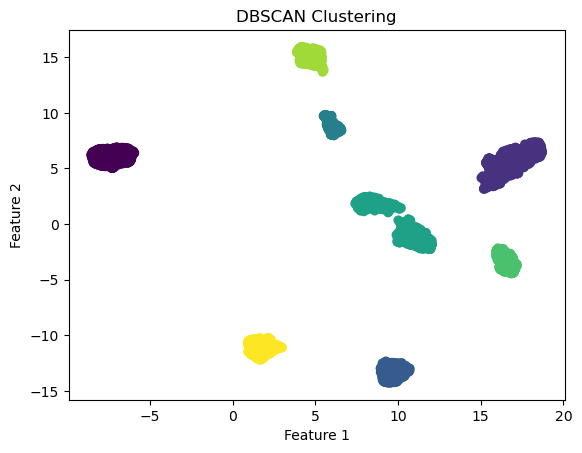

In [1358]:
dbscan = DBSCAN_(random_state=12)
dbscan.fit(X_train_umap)
# Instanciar LabelEncoder
le = LabelEncoder()
train_pred = dbscan.predict(X_train_umap)
train_labels = le.fit_transform(np.array(Y_train).reshape(Y_train.shape[0]))

plot_scatter_dbscan(X_train_umap, train_pred)

#### Val

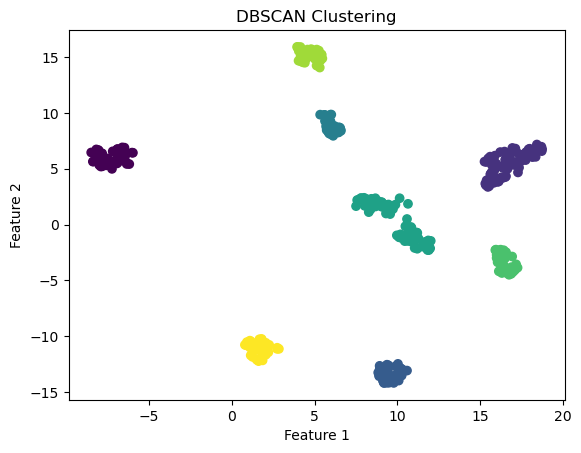

In [1360]:
val_pred = dbscan.predict(X_val_umap)
val_labels = le.fit_transform(np.array(Y_val).reshape(Y_val.shape[0]))

plot_scatter_dbscan(X_val_umap, val_pred)

#### Results

In [1362]:
print(adjusted_rand_score(val_labels, val_pred))
print(silhouette_score(X_val_umap, val_pred))

0.7530384221694557
0.8058785


#### Test classification

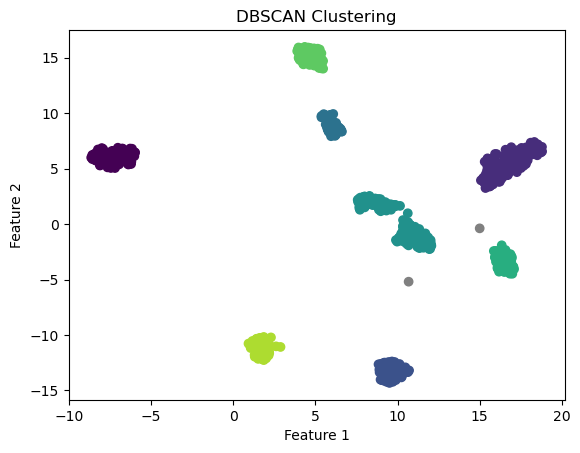

In [1364]:
test_pred = dbscan.predict(X_test_umap)
plot_scatter_dbscan(X_test_umap, test_pred)
create_clustered_dataframe(test_pred,'./output/r2plus1d_34_8_ig65m_ft_kinetics/test_output_2d_dbscan.csv')


### Gaussian-Mixture

In [1366]:
class GaussianMixtureModel_:
    def __init__(self, k=3, epochs=1000, err=1e-5, random_state=None):
        self.k = k
        self.epochs = epochs
        self.err = err
        self.random_state = random_state
        self.centroids = None
        self.pi = None
        self.complete_covariance = None

    def fit(self, data):
        n_samples, n_features = data.shape

        # Initialize with KMeans++
 
        kmeans = KMeans_(K=self.k, random_state=self.random_state)

        kmeans.fit(data)
        self.centroids = kmeans.centroids

        self.pi = np.full(self.k, 1.0 / self.k)
        self.complete_covariance = np.array([np.identity(n_features) for _ in range(self.k)])
        max_log_likelihood = -np.inf
        best_centroids = self.centroids
        best_covariance = self.complete_covariance
        best_pi = self.pi

        for _ in range(self.epochs):
            # E-Step: Compute responsibilities (gamma_nk)
            gaussian_result = np.zeros((self.k, n_samples))
            for i in range(self.k):
                gaussian_result[i, :] = self.multivariate_gaussian(data, self.centroids[i], self.complete_covariance[i])

            sum_nk = np.dot(self.pi, gaussian_result)
            gamma_nk = (self.pi[:, np.newaxis] * gaussian_result) / (sum_nk + self.err)

            # M-Step: Update parameters
            self.pi = gamma_nk.sum(axis=1) / n_samples
            self.centroids = np.dot(gamma_nk, data) / gamma_nk.sum(axis=1)[:, np.newaxis]

            for i in range(self.k):
                diff = data - self.centroids[i]
                self.complete_covariance[i] = np.dot(gamma_nk[i] * diff.T, diff) / gamma_nk[i].sum()
                self.complete_covariance[i] += np.eye(n_features) * self.err

            # Log likelihood
            log_likelihood = np.sum(np.log(sum_nk + self.err))
            if log_likelihood > max_log_likelihood:
                max_log_likelihood = log_likelihood
                best_centroids = self.centroids
                best_covariance = self.complete_covariance
                best_pi = self.pi

        self.centroids = best_centroids
        self.complete_covariance = best_covariance
        self.pi = best_pi

    def multivariate_gaussian(self, data, mu, cov):
        n = data.shape[1]
        cov += np.eye(n) * self.err
        diff = data - mu
        inv_cov = np.linalg.inv(cov)
        norm_factor = np.sqrt((2 * np.pi) ** n * np.linalg.det(cov))
        exp_factor = np.exp(-0.5 * np.sum(np.dot(diff, inv_cov) * diff, axis=1))
        return exp_factor / norm_factor

    def compute_gammank_gaussian(self, data):
        gaussian_result = np.zeros((self.k, len(data)))
        for i in range(self.k):
            gaussian_result[i, :] = self.multivariate_gaussian(data, self.centroids[i], self.complete_covariance[i])
        sum_nk = np.dot(self.pi, gaussian_result)
        gamma_nk = (self.pi[:, np.newaxis] * gaussian_result) / (sum_nk + self.err)
        return gamma_nk

    def predict(self, data):
        gamma = self.compute_gammank_gaussian(data)
        return np.argmax(gamma, axis=0)


In [1367]:
def plot_gaussian_mixture(data, model, labels):
    plt.figure(figsize=(10, 6))
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k', alpha=0.6)

    for i in range(model.k):
        plot_cov_ellipse(model.complete_covariance[i], model.centroids[i], nstd=2, alpha=0.5, edgecolor='red')

    plt.scatter(model.centroids[:, 0], model.centroids[:, 1], c='white', marker='.', s=100, linewidths=3)
    plt.title('Distribución de Clases Predichas y Elipses de Covarianza')
    plt.xlabel('Característica 1')
    plt.ylabel('Característica 2')
    plt.show()

def plot_cov_ellipse(cov, pos, nstd=2, **kwargs):
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    width, height = 2 * nstd * np.sqrt(eigvals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=angle, **kwargs)
    ax = plt.gca()
    ax.add_artist(ellip)

#### Train

In [1566]:
GMM = GaussianMixtureModel_(k=10,random_state=12)
GMM.fit(X_train_umap)

In [1567]:
train_pred = GMM.predict(X_train_umap)
train_labels = le.fit_transform(np.array(Y_train).reshape(Y_train.shape[0]))

#### Val

TypeError: arctan2() takes from 2 to 3 positional arguments but 50 were given

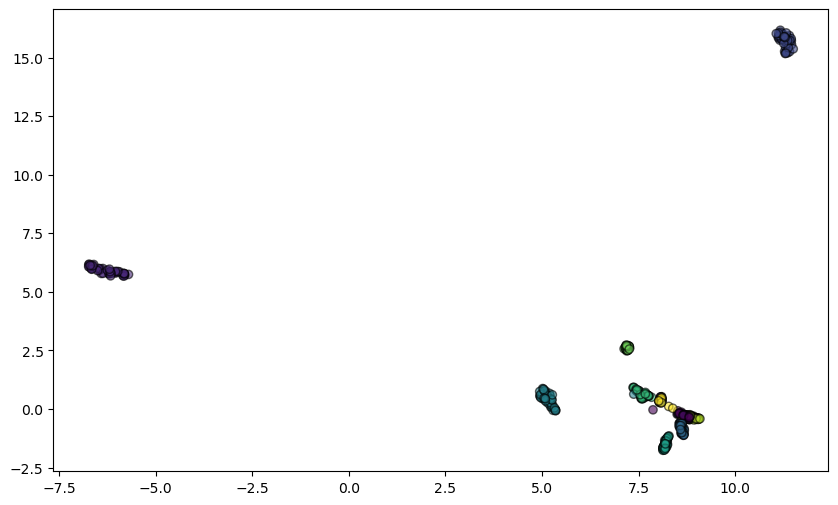

In [1568]:
val_pred = GMM.predict(X_val_umap)
val_labels = le.fit_transform(np.array(Y_val).reshape(Y_val.shape[0]))

plot_gaussian_mixture(X_val_umap, GMM, X_val_pred)

#### Results

In [1374]:
print(adjusted_rand_score(val_labels, val_pred))
print(silhouette_score(X_val_umap, val_pred))

0.8819437050637805
0.75588465


#### Test classification

In [1376]:
test_pred = GMM.predict(X_test_umap)
create_clustered_dataframe(test_pred,'./output/r2plus1d_34_8_ig65m_ft_kinetics/test_output_2d_gmm.csv')

## Clustering in 50d

In [1378]:
UMAP = umap.UMAP(n_components=50,random_state=12, n_jobs=-1)
X_train_umap = UMAP.fit_transform(X_train_s)
X_val_umap = UMAP.transform(X_val_s)
X_test_umap = UMAP.transform(X_test_s)

/opt/anaconda3/envs/MachineL/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


### Kmeans

#### Train

In [1381]:
# Definir y ajustar el modelo de KMeansUTEC
kmeans = KMeans_(K=10, random_state=12)
kmeans.fit(X_train_umap)
# Instanciar LabelEncoder
le = LabelEncoder()
train_pred = kmeans.predict(X_train_umap)
train_labels = le.fit_transform(np.array(Y_train).reshape(Y_train.shape[0]))

#### Val

In [1383]:
val_pred = kmeans.predict(X_val_umap)
val_labels = le.fit_transform(np.array(Y_val).reshape(Y_val.shape[0]))


#### Results

In [1385]:
print(adjusted_rand_score(val_labels, val_pred))
print(silhouette_score(X_val_umap, val_pred))

0.8004022706906452
0.79732


#### Test classification

In [1387]:
test_pred = kmeans.predict(X_test_umap)
create_clustered_dataframe(test_pred,'./output/r2plus1d_34_8_ig65m_ft_kinetics/test_output_50d_kmeanspp.csv')


### Dbscan

#### Train

In [1390]:
dbscan = DBSCAN_(random_state=12)
dbscan.fit(X_train_umap)
# Instanciar LabelEncoder
le = LabelEncoder()
train_pred = dbscan.predict(X_train_umap)
train_labels = le.fit_transform(np.array(Y_train).reshape(Y_train.shape[0]))

#### Val

In [1392]:
val_pred = dbscan.predict(X_val_umap)
val_labels = le.fit_transform(np.array(Y_val).reshape(Y_val.shape[0]))

#### Results

In [1394]:
print(adjusted_rand_score(val_labels, val_pred))
print(silhouette_score(X_val_umap, val_pred))

0.7632255305742601
0.7778203


#### Test classification

In [1396]:
test_pred = dbscan.predict(X_test_umap)
create_clustered_dataframe(test_pred,'./output/r2plus1d_34_8_ig65m_ft_kinetics/test_output_50d_dbscan.csv')


### Gaussian-Mixture

#### Train

In [ ]:
GMM = GaussianMixtureModel_(k=10,random_state=12)
GMM.fit(X_train_umap)

In [1400]:
train_pred = GMM.predict(X_train_umap)
train_labels = le.fit_transform(np.array(Y_train).reshape(Y_train.shape[0]))

#### Val

In [1402]:
val_pred = GMM.predict(X_val_umap)
val_labels = le.fit_transform(np.array(Y_val).reshape(Y_val.shape[0]))

#### Results

In [1404]:
print(adjusted_rand_score(val_labels, val_pred))
print(silhouette_score(X_val_umap, val_pred))

0.8050264994208781
0.79434747


#### Test classification

In [1406]:
test_pred = GMM.predict(X_test_umap)
create_clustered_dataframe(test_pred,'./output/r2plus1d_34_8_ig65m_ft_kinetics/test_output_50d_gmm.csv')

# Dataset r2plus1d_34_32_ig65m_ft_kinetics

## Procesar los features extraídos

### Obtener un feature vector por cada video

In [1410]:

df_train_labels = pd.read_csv(
    "./url_data/train_subset_10.csv", header=None, names=["youtube_id", "label"]
)
df_val_labels = pd.read_csv(
    "./url_data/val_subset_10.csv", header=None, names=["youtube_id", "label"]
)
df_test_labels = pd.read_csv(
    "./url_data/test_subset_10.csv", header=None, names=["youtube_id", "label"]
)
df_train_labels.drop(index=df_train_labels.index[0], axis=0, inplace=True)
df_val_labels.drop(index=df_val_labels.index[0], axis=0, inplace=True)
df_test_labels.drop(index=df_test_labels.index[0], axis=0, inplace=True)

df_test_labels.head()

,youtube_id,label
1,oaVWnxlQOeo,NaN
2,7zMBk9Zu9fY,NaN
3,DwPEZeX5WkA,NaN
4,bO1MW9Lq9Sg,NaN
5,TdBpD9Ccg9w,NaN


### Obtener la data de entrenamiento, validación y de testeo

In [1412]:
models_r21d = ["r2plus1d_18_16_kinetics","r2plus1d_34_32_ig65m_ft_kinetics","r2plus1d_34_8_ig65m_ft_kinetics"]
urls_train, X_train, Y_train = process_video_data(
    f"./numpy_data/train/r21d/{models_r21d[1]}/", df_train_labels
)

urls_train.dropna(inplace=True)
X_train.dropna(inplace=True)
Y_train.dropna(inplace=True)

print(f"\nNúmero de videos cargados para entrenamiento: {len(X_train)}")
print(f"Shape de nuestra matriz de videos para entrenamiento: {X_train.shape}")


Number of empty videos not included (./numpy_data/train/r21d/r2plus1d_34_32_ig65m_ft_kinetics/): 6
Labels of empty videos not included: ['EQULJzMzmeM', 'W6TspTTHpzA', '-reNwipPPdQ', 'oRwkPwoFIL8', 'yqJXWU8BXEQ', 'B3L0x-AsCZ4']

Número de videos cargados para entrenamiento: 5409
Shape de nuestra matriz de videos para entrenamiento: (5409, 512)


In [1413]:
urls_val, X_val, Y_val = process_video_data(
    f"./numpy_data/val/r21d/{models_r21d[1]}/", df_val_labels
)

urls_val.dropna(inplace=True)
X_val.dropna(inplace=True)
Y_val.dropna(inplace=True)

print(f"\nNúmero de videos cargados para validación: {len(X_val)}")
print(f"Shape de nuestra matriz de videos para validación: {X_val.shape}")


Number of empty videos not included (./numpy_data/val/r21d/r2plus1d_34_32_ig65m_ft_kinetics/): 0
Labels of empty videos not included: []

Número de videos cargados para validación: 426
Shape de nuestra matriz de videos para validación: (426, 512)


In [1414]:
urls_test, X_test, Y_test = process_video_data(
    f"./numpy_data/test/r21d/{models_r21d[1]}/", df_test_labels
)
urls_test.dropna(inplace=True)
X_test.dropna(inplace=True)
Y_test.dropna(inplace=True)

print(f"\nNúmero de videos cargados para testeo: {len(X_test)}")
print(f"Shape de nuestra matriz de videos para testeo: {X_test.shape}")

Number of empty videos not included (./numpy_data/test/r21d/r2plus1d_34_32_ig65m_ft_kinetics/): 1
Labels of empty videos not included: ['se3ihwZ56Uw']

Número de videos cargados para testeo: 804
Shape de nuestra matriz de videos para testeo: (804, 512)


## Preprocesamiento de la data

### Escalar los datos

In [1417]:
Scaler = PowerTransformer(method="yeo-johnson") # Utilizaremos el PowerTransformer para asemejar la data a una forma gaussiana
X_train_s = Scaler.fit_transform(X_train)
X_val_s = Scaler.transform(X_val)
X_test_s = Scaler.transform(X_test)


### Reduce dimensionality

#### Random Projection

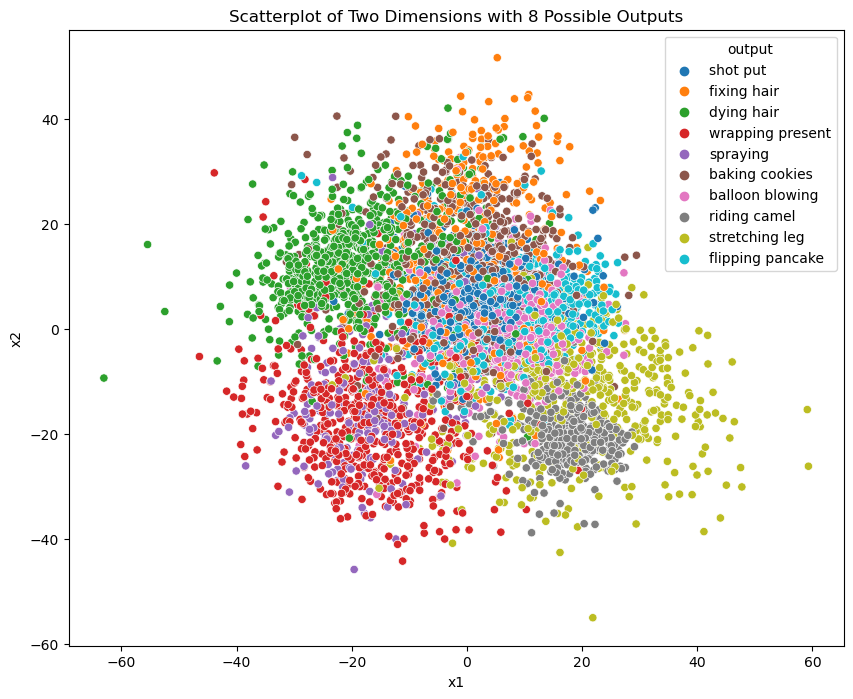

In [1420]:
RP = random_projection.GaussianRandomProjection(n_components=2,random_state=12)
X_train_rp = RP.fit_transform(X_train_s)
X_val_rp = RP.transform(X_val_s)
X_test_rp = RP.transform(X_test_s)
X_train_rp.shape
df_ = pd.concat([pd.DataFrame(X_train_rp), Y_train], axis = 1)
df_.columns = ["x1","x2","output"]
# Crear el scatterplot con Seaborn
plt.figure(figsize=(10, 8))
scatter_plot = sns.scatterplot(data=df_, x='x1', y='x2', hue='output')
plt.title('Scatterplot of Two Dimensions with 8 Possible Outputs')
plt.show()

#### UMAP

/opt/anaconda3/envs/MachineL/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


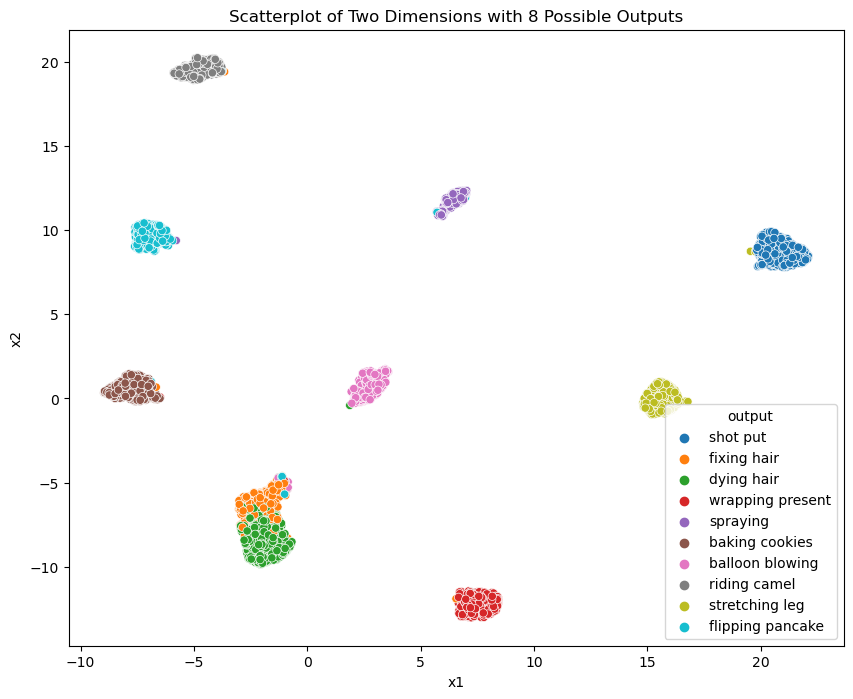

In [1422]:
UMAP = umap.UMAP(random_state=12, n_jobs=-1)
X_train_umap = UMAP.fit_transform(X_train_s)
X_val_umap = UMAP.transform(X_val_s)
X_test_umap = UMAP.transform(X_test_s)
X_train_umap.shape
df_ = pd.concat([pd.DataFrame(X_train_umap), Y_train], axis = 1)
df_.columns = ["x1","x2","output"]
# Crear el scatterplot con Seaborn
plt.figure(figsize=(10, 8))
scatter_plot = sns.scatterplot(data=df_, x='x1', y='x2', hue='output')
plt.title('Scatterplot of Two Dimensions with 8 Possible Outputs')
plt.show()

#### PCA

(5409, 100)


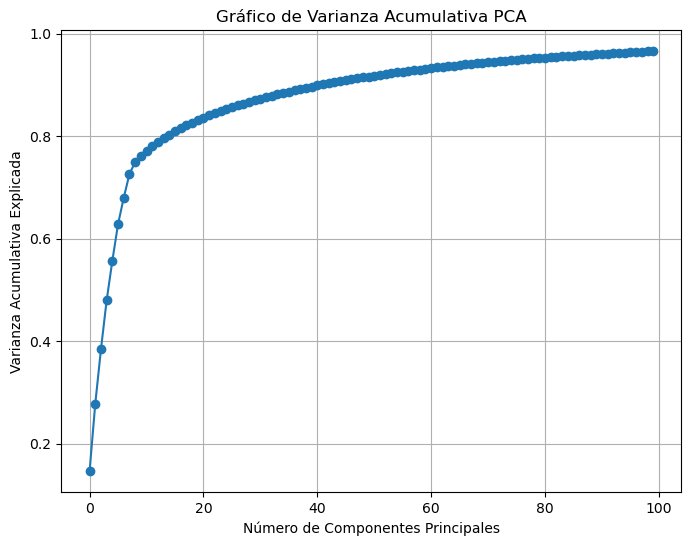

In [1424]:
pca = PCA(n_components=100,random_state=12)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape)

explained_variance = pca.explained_variance_ratio_
# Assuming 'explained_variance' is already defined
cumulative_variance = np.cumsum(explained_variance)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(np.arange(0, 100), cumulative_variance[:100], marker='o', linestyle='-')
plt.title('Gráfico de Varianza Acumulativa PCA')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Acumulativa Explicada')
plt.grid(True)
plt.show()

In [1425]:
def create_clustered_dataframe(pred, output_csv_path):
    test_export = pd.concat([urls_test,pd.DataFrame(pred)], axis=1)
    test_export.columns = ["youtube_id", "labels"]
    test_url_sort = pd.read_csv(
    "./url_data/test_subset_10.csv", header=None, names=["youtube_id"]
    )
    test_url_sort.drop(index=test_url_sort.index[0], axis=0, inplace=True)
    
    # Merge de los dos DataFrames basado en youtube_id
    merged_df = pd.merge(test_url_sort, test_export, on='youtube_id', how='left')

    # Guardar el DataFrame resultante en un nuevo CSV
    merged_df.to_csv(output_csv_path, index=False)
    
def create_clustered_missing_dataframe(pred, output_csv_path):
    test_export = pd.concat([urls_test, pd.DataFrame(pred)], axis=1)
    test_export.columns = ["youtube_id", "labels"]
    
    test_url_sort = pd.read_csv(
        "./url_data/test_subset_10.csv", header=None, names=["youtube_id"]
    )
    test_url_sort.drop(index=test_url_sort.index[0], axis=0, inplace=True)
    
    # Añadir las filas faltantes con label 0
    missing_ids = test_url_sort[~test_url_sort['youtube_id'].isin(test_export['youtube_id'])]
    missing_ids['labels'] = 0
    
    # Concatenar las filas faltantes al test_export
    test_export = pd.concat([test_export, missing_ids], axis=0)
    
    # Merge de los dos DataFrames basado en youtube_id
    merged_df = pd.merge(test_url_sort, test_export, on='youtube_id', how='left')

    # Guardar el DataFrame resultante en un nuevo CSV
    merged_df.to_csv(output_csv_path, index=False)

## Clustering in 2d

### Kmeans

#### Train

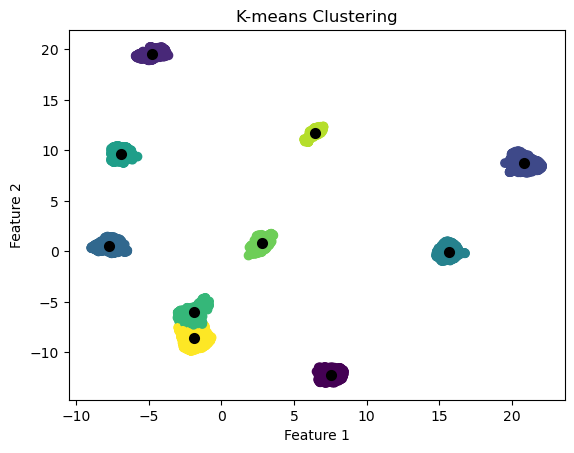

In [1429]:
kmeans = KMeans_(K=10, random_state=11)
kmeans.fit(X_train_umap)
# Instanciar LabelEncoder
le = LabelEncoder()
train_pred = kmeans.predict(X_train_umap)
train_labels = le.fit_transform(np.array(Y_train).reshape(Y_train.shape[0]))

plot_scatter_kmeans(X_train_umap, kmeans, train_pred)

#### Val

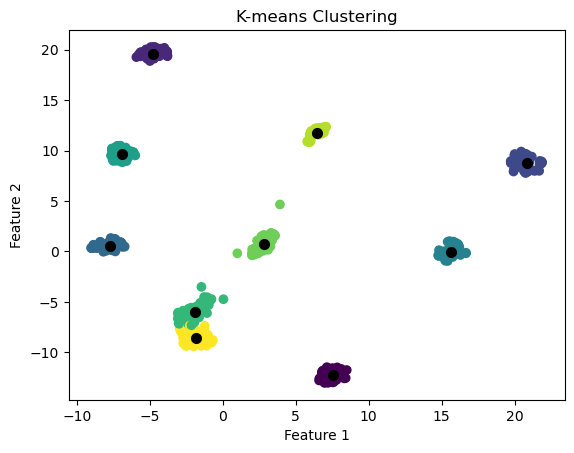

In [1431]:
val_pred = kmeans.predict(X_val_umap)
val_labels = le.fit_transform(np.array(Y_val).reshape(Y_val.shape[0]))

plot_scatter_kmeans(X_val_umap, kmeans, val_pred)

#### Results

In [1433]:
print(adjusted_rand_score(val_labels, val_pred))
print(silhouette_score(X_val_umap, val_pred))

0.8964538321962948
0.8241765


#### Test classification

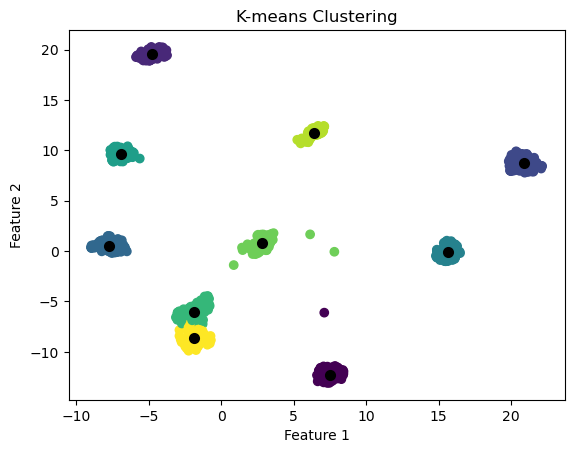

/var/folders/80/pl2pdk595tgbq9tgh3qh84kc0000gn/T/ipykernel_67864/561564510.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_ids['labels'] = 0


In [1435]:
test_pred = kmeans.predict(X_test_umap)
plot_scatter_kmeans(X_test_umap, kmeans, test_pred)
clustered_missing_test(test_pred,'./output/r2plus1d_34_32_ig65m_ft_kinetics/test_output_2d_kmeanspp.csv')

### Dbscan

#### Train

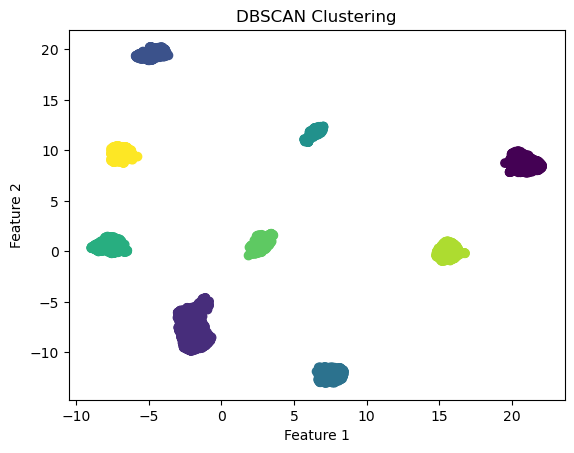

In [1438]:
dbscan = DBSCAN_(random_state=11)
dbscan.fit(X_train_umap)
# Instanciar LabelEncoder
le = LabelEncoder()
train_pred = dbscan.predict(X_train_umap)
train_labels = le.fit_transform(np.array(Y_train).reshape(Y_train.shape[0]))

plot_scatter_dbscan(X_train_umap, train_pred)

#### Val

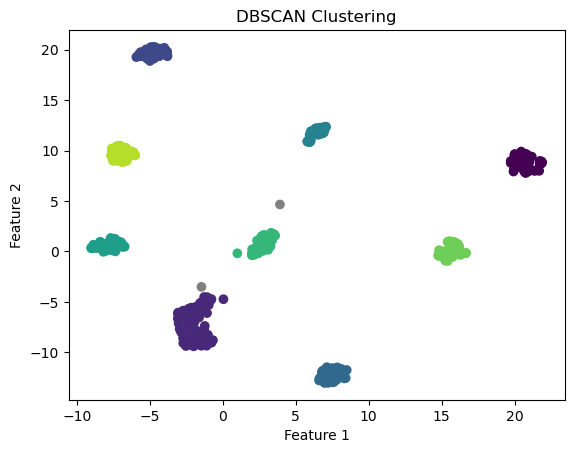

In [1440]:
val_pred = dbscan.predict(X_val_umap)
val_labels = le.fit_transform(np.array(Y_val).reshape(Y_val.shape[0]))

plot_scatter_dbscan(X_val_umap, val_pred)

#### Results

In [1442]:
print(adjusted_rand_score(val_labels, val_pred))
print(silhouette_score(X_val_umap, val_pred))

0.8499393539150417
0.8566221


#### Test classification

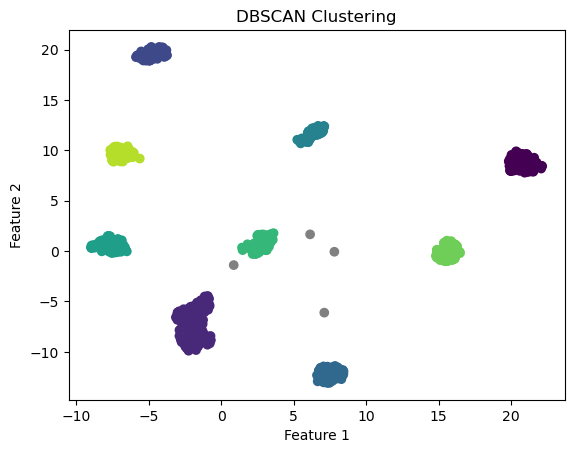

/var/folders/80/pl2pdk595tgbq9tgh3qh84kc0000gn/T/ipykernel_67864/1532207649.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_ids['labels'] = 0


In [1444]:
test_pred = dbscan.predict(X_test_umap)
plot_scatter_dbscan(X_test_umap, test_pred)
create_clustered_missing_dataframe(test_pred,'./output/r2plus1d_34_32_ig65m_ft_kinetics/test_output_2d_dbscan.csv')


### Gaussian-Mixture

#### Train

In [1447]:
GMM = GaussianMixtureModel_(k=10, random_state=11)
GMM.fit(X_train_umap)

In [1448]:
train_pred = GMM.predict(X_train_umap)
train_labels = le.fit_transform(np.array(Y_train).reshape(Y_train.shape[0]))

#### Val

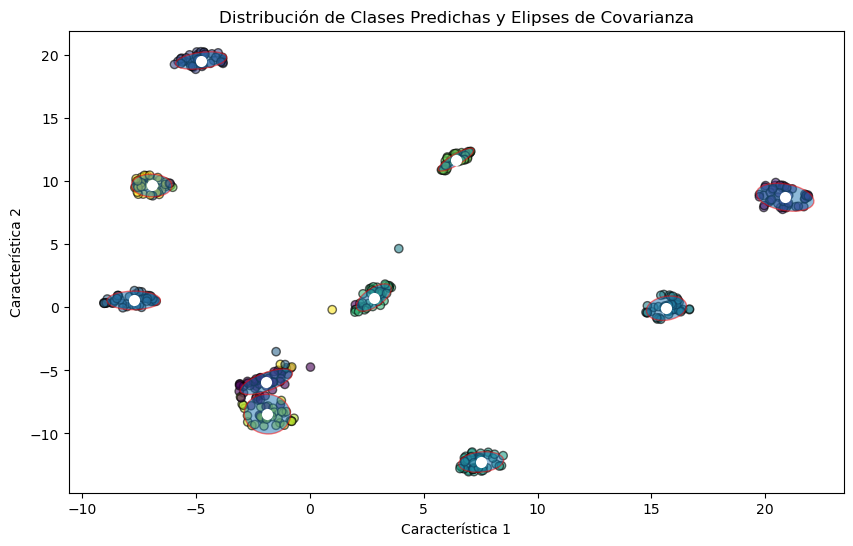

In [1450]:
val_pred = GMM.predict(X_val_umap)
val_labels = le.fit_transform(np.array(Y_val).reshape(Y_val.shape[0]))

plot_gaussian_mixture(X_val_umap, GMM, X_val_pred)

#### Results

In [1452]:
print(adjusted_rand_score(val_labels, val_pred))
print(silhouette_score(X_val_umap, val_pred))

0.9096984806481001
0.823411


#### Test classification

In [1454]:
test_pred = GMM.predict(X_test_umap)
clustered_missing_test(test_pred,'./output/r2plus1d_34_32_ig65m_ft_kinetics/test_output_2d_gmm.csv')

/var/folders/80/pl2pdk595tgbq9tgh3qh84kc0000gn/T/ipykernel_67864/561564510.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_ids['labels'] = 0


## Clustering in 50d

In [1456]:
UMAP = umap.UMAP(n_components=50,random_state=12, n_jobs=-1)
X_train_umap = UMAP.fit_transform(X_train_s)
X_val_umap = UMAP.transform(X_val_s)
X_test_umap = UMAP.transform(X_test_s)

/opt/anaconda3/envs/MachineL/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


### Kmeans

#### Train

In [1459]:
kmeans = KMeans_(K=10, random_state=11)
kmeans.fit(X_train_umap)
# Instanciar LabelEncoder
le = LabelEncoder()
train_pred = kmeans.predict(X_train_umap)
train_labels = le.fit_transform(np.array(Y_train).reshape(Y_train.shape[0]))

#### Val

In [1461]:
val_pred = kmeans.predict(X_val_umap)
val_labels = le.fit_transform(np.array(Y_val).reshape(Y_val.shape[0]))


#### Results

In [1463]:
print(adjusted_rand_score(val_labels, val_pred))
print(silhouette_score(X_val_umap, val_pred))

0.9008826853553158
0.8385892


#### Test classification

In [1465]:
test_pred = kmeans.predict(X_test_umap)
create_clustered_missing_dataframe(test_pred,'./output/r2plus1d_34_32_ig65m_ft_kinetics/test_output_50d_kmeanspp.csv')


/var/folders/80/pl2pdk595tgbq9tgh3qh84kc0000gn/T/ipykernel_67864/1532207649.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_ids['labels'] = 0


### Dbscan

#### Train

In [1468]:
dbscan = DBSCAN_(random_state=11)
dbscan.fit(X_train_umap)
# Instanciar LabelEncoder
le = LabelEncoder()
train_pred = dbscan.predict(X_train_umap)
train_labels = le.fit_transform(np.array(Y_train).reshape(Y_train.shape[0]))

#### Val

In [1470]:
val_pred = dbscan.predict(X_val_umap)
val_labels = le.fit_transform(np.array(Y_val).reshape(Y_val.shape[0]))

#### Results

In [1472]:
print(adjusted_rand_score(val_labels, val_pred))
print(silhouette_score(X_val_umap, val_pred))

0.8539307244211934
0.8823207


#### Test classification

In [1474]:
test_pred = dbscan.predict(X_test_umap)
create_clustered_missing_dataframe(test_pred,'./output/r2plus1d_34_32_ig65m_ft_kinetics/test_output_50d_dbscan.csv')


/var/folders/80/pl2pdk595tgbq9tgh3qh84kc0000gn/T/ipykernel_67864/1532207649.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_ids['labels'] = 0


### Gaussian-Mixture

#### Train

In [1477]:
GMM = GaussianMixtureModel_(k=10, random_state=11)
GMM.fit(X_train_umap)

In [1478]:
train_pred = GMM.predict(X_train_umap)
train_labels = le.fit_transform(np.array(Y_train).reshape(Y_train.shape[0]))

#### Val

In [1480]:
val_pred = GMM.predict(X_val_umap)
val_labels = le.fit_transform(np.array(Y_val).reshape(Y_val.shape[0]))

#### Results

In [1482]:
print(adjusted_rand_score(val_labels, val_pred))
print(silhouette_score(X_val_umap, val_pred))

0.8847917086236209
0.82364535


#### Test classification

In [1484]:
test_pred = GMM.predict(X_test_umap)
create_clustered_missing_dataframe(test_pred,'./output/r2plus1d_34_32_ig65m_ft_kinetics/test_output_50d_gmm.csv')

/var/folders/80/pl2pdk595tgbq9tgh3qh84kc0000gn/T/ipykernel_67864/1532207649.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_ids['labels'] = 0
